# Data Preprocessing

In [445]:
import random
import numpy as np
import pandas
import tflearn
import datetime
import matplotlib.pyplot as plt
import sklearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.layers.recurrent import lstm
from datetime import date, timedelta

In [446]:
df = pd.read_csv("./TXF1_2017.txt")

In [447]:
df.iloc[:10]

,Date,Time,Open,High,Low,Close,Volume
0,2000/1/4,09:01:00,8688,8688,8676,8680,67
1,2000/1/4,09:02:00,8662,8698,8662,8698,52
2,2000/1/4,09:03:00,8698,8700,8690,8700,31
3,2000/1/4,09:04:00,8700,8700,8680,8700,38
4,2000/1/4,09:05:00,8700,8700,8652,8680,44
5,2000/1/4,09:06:00,8650,8685,8650,8660,17
6,2000/1/4,09:07:00,8670,8670,8660,8665,14
7,2000/1/4,09:08:00,8662,8670,8660,8670,24
8,2000/1/4,09:09:00,8670,8685,8665,8685,29
9,2000/1/4,09:10:00,8685,8690,8680,8690,8


In [450]:
# X
df['MA5'] = pd.rolling_mean(df['Close'], 5)
df['MA10'] = pd.rolling_mean(df['Close'], 10)
df['MA20'] = pd.rolling_mean(df['Close'], 20)
df['RSV'] = (df['Close'] - pd.rolling_min(df['Low'], 9)) / (pd.rolling_max(df['High'], 9) - pd.rolling_min(df['Low'], 9))
df['K'] = pd.ewma(df['RSV'], adjust=False, alpha=1/3)
df['D'] = pd.ewma(df['K'], adjust=False, alpha=1/3)
TR = pd.concat([df[['High', 'Low']], df['Close'].shift(1)], axis=1, ignore_index=True)
df['TR'] = TR.max(axis=1) - TR.min(axis=1)
df['ATR'] = pd.ewma(df['TR'], adjust=False, alpha=1/15)
df['TRMA'] = pd.rolling_mean(df['TR'], 15)
df['DM_P'] = np.where((df['High'] - df['High'].shift(1)) > 0, df['High'] - df['High'].shift(1), 0)
df['DM_N'] = np.where((df['Low'] - df['Low'].shift(1)) < 0, df['Low'].shift(1) - df['Low'], 0)
df['ADM_P'] = pd.ewma(df['DM_P'], adjust=False, alpha=1/15)
df['ADM_N'] = pd.ewma(df['DM_N'], adjust=False, alpha=1/15)
df['DX'] = ((df['ADM_P'] - df['ADM_N']) / (df['ADM_P'] + df['ADM_N'])).abs() * 100
df['ADX'] = pd.ewma(df['DX'], adjust=False, alpha=1/15)

In [451]:
df.iloc[:30]

,Date,Time,Open,High,Low,Close,Volume,MA5,MA10,MA20,...,D,TR,ATR,TRMA,DM_P,DM_N,ADM_P,ADM_N,DX,ADX
0,2000/1/4,09:01:00,8688,8688,8676,8680,67,NaN,NaN,NaN,...,NaN,12.0,12.000000,NaN,0.0,0.0,0.000000,0.000000,NaN,NaN
1,2000/1/4,09:02:00,8662,8698,8662,8698,52,NaN,NaN,NaN,...,NaN,36.0,13.600000,NaN,10.0,14.0,0.666667,0.933333,16.666667,16.666667
2,2000/1/4,09:03:00,8698,8700,8690,8700,31,NaN,NaN,NaN,...,NaN,10.0,13.360000,NaN,2.0,0.0,0.755556,0.871111,7.103825,16.029144
3,2000/1/4,09:04:00,8700,8700,8680,8700,38,NaN,NaN,NaN,...,NaN,20.0,13.802667,NaN,0.0,10.0,0.705185,1.479704,35.448874,17.323793
4,2000/1/4,09:05:00,8700,8700,8652,8680,44,8691.6,NaN,NaN,...,NaN,48.0,16.082489,NaN,0.0,28.0,0.658173,3.247723,66.298499,20.588773
5,2000/1/4,09:06:00,8650,8685,8650,8660,17,8687.6,NaN,NaN,...,NaN,35.0,17.343656,NaN,0.0,2.0,0.614295,3.164542,67.487630,23.715364
6,2000/1/4,09:07:00,8670,8670,8660,8665,14,8681.0,NaN,NaN,...,NaN,10.0,16.854079,NaN,0.0,0.0,0.573342,2.953572,67.487630,26.633515
7,2000/1/4,09:08:00,8662,8670,8660,8670,24,8675.0,NaN,NaN,...,NaN,10.0,16.397141,NaN,0.0,0.0,0.535119,2.756668,67.487630,29.357122
8,2000/1/4,09:09:00,8670,8685,8665,8685,29,8672.0,NaN,NaN,...,0.700000,20.0,16.637331,NaN,15.0,0.0,1.499444,2.572890,26.359465,29.157279
9,2000/1/4,09:10:00,8685,8690,8680,8690,8,8674.0,8682.8,NaN,...,0.711111,10.0,16.194842,NaN,5.0,0.0,1.732815,2.401364,16.171268,28.291545


In [452]:
# y
future_p = pd.concat([(df['Close'].shift(-1)>df['Close']), (df['Close'].shift(-2)>df['Close']), (df['Close'].shift(-3)>df['Close']), (df['Close'].shift(-4)>df['Close']), (df['Close'].shift(-5)>df['Close'])], axis=1)
df['y'] = future_p.sum(axis=1)/5

In [453]:
df.iloc[:10]

,Date,Time,Open,High,Low,Close,Volume,MA5,MA10,MA20,...,TR,ATR,TRMA,DM_P,DM_N,ADM_P,ADM_N,DX,ADX,y
0,2000/1/4,09:01:00,8688,8688,8676,8680,67,NaN,NaN,NaN,...,12.0,12.000000,NaN,0.0,0.0,0.000000,0.000000,NaN,NaN,0.6
1,2000/1/4,09:02:00,8662,8698,8662,8698,52,NaN,NaN,NaN,...,36.0,13.600000,NaN,10.0,14.0,0.666667,0.933333,16.666667,16.666667,0.4
2,2000/1/4,09:03:00,8698,8700,8690,8700,31,NaN,NaN,NaN,...,10.0,13.360000,NaN,2.0,0.0,0.755556,0.871111,7.103825,16.029144,0.0
3,2000/1/4,09:04:00,8700,8700,8680,8700,38,NaN,NaN,NaN,...,20.0,13.802667,NaN,0.0,10.0,0.705185,1.479704,35.448874,17.323793,0.0
4,2000/1/4,09:05:00,8700,8700,8652,8680,44,8691.6,NaN,NaN,...,48.0,16.082489,NaN,0.0,28.0,0.658173,3.247723,66.298499,20.588773,0.4
5,2000/1/4,09:06:00,8650,8685,8650,8660,17,8687.6,NaN,NaN,...,35.0,17.343656,NaN,0.0,2.0,0.614295,3.164542,67.487630,23.715364,1.0
6,2000/1/4,09:07:00,8670,8670,8660,8665,14,8681.0,NaN,NaN,...,10.0,16.854079,NaN,0.0,0.0,0.573342,2.953572,67.487630,26.633515,1.0
7,2000/1/4,09:08:00,8662,8670,8660,8670,24,8675.0,NaN,NaN,...,10.0,16.397141,NaN,0.0,0.0,0.535119,2.756668,67.487630,29.357122,1.0
8,2000/1/4,09:09:00,8670,8685,8665,8685,29,8672.0,NaN,NaN,...,20.0,16.637331,NaN,15.0,0.0,1.499444,2.572890,26.359465,29.157279,0.8
9,2000/1/4,09:10:00,8685,8690,8680,8690,8,8674.0,8682.8,NaN,...,10.0,16.194842,NaN,5.0,0.0,1.732815,2.401364,16.171268,28.291545,0.8


In [499]:
X = df
X['Close'] = X['Close'].shift(1)
X['SIGNAL'] = np.where(X['y']>0.5, 1, 0)
X['SIGN'] = X['SIGNAL'].shift(5)

In [500]:
train_n = int(len(X)*0.8)
train_x = X.iloc[20:train_n].drop(['Date', 'Time', 'Open', 'High', 'Low', 'Volume', 'y', 'SIGNAL'], axis=1).fillna(0)
train_y = X['SIGNAL'].iloc[20:train_n].fillna(0)
test_x = X.iloc[train_n:].drop(['Date', 'Time', 'Open', 'High', 'Low', 'Volume', 'y', 'SIGNAL'], axis=1).fillna(0)
test_y = X['SIGNAL'].iloc[train_n:].fillna(0)


In [501]:
train_x.iloc[:]

,Close,MA5,MA10,MA20,RSV,K,D,TR,ATR,TRMA,DM_P,DM_N,ADM_P,ADM_N,DX,ADX,SIGN
20,8710.0,8742.2,8720.1,8702.25,0.983051,0.971216,0.938657,3.0,13.353000,11.600000,0.0,0.0,4.131362,1.738650,40.761614,26.227966,1.0
21,8720.0,8748.2,8727.1,8704.85,0.933333,0.958589,0.945301,4.0,12.729466,11.200000,1.0,0.0,3.922605,1.622740,41.473783,27.244354,1.0
22,8738.0,8749.2,8731.9,8707.00,0.796296,0.904491,0.931698,7.0,12.347502,11.000000,0.0,7.0,3.661098,1.981224,29.772732,27.412912,1.0
23,8748.0,8749.6,8737.4,8709.50,0.909091,0.906024,0.923140,10.0,12.191002,10.333333,0.0,3.0,3.417025,2.049143,25.024515,27.253686,1.0
24,8753.0,8748.0,8740.9,8712.75,0.735294,0.849114,0.898465,10.0,12.044935,10.333333,0.0,0.0,3.189223,1.912533,25.024515,27.105074,0.0
25,8752.0,8745.6,8743.9,8716.75,0.461538,0.719922,0.838951,5.0,11.575273,10.000000,0.0,0.0,2.976608,1.785031,25.024515,26.966370,0.0
26,8750.0,8743.6,8745.9,8720.50,0.222222,0.554022,0.743974,4.0,11.070254,8.933333,0.0,4.0,2.778167,1.932696,17.947283,26.365098,0.0
27,8743.0,8743.0,8746.1,8724.00,0.222222,0.443422,0.643790,0.0,10.332238,7.933333,0.0,0.0,2.592956,1.803849,17.947283,25.803910,0.0
28,8750.0,8741.0,8745.3,8726.75,0.222222,0.369689,0.552423,1.0,9.710088,7.933333,1.0,0.0,2.486759,1.683593,19.258967,25.367581,0.0
29,8745.0,8739.2,8743.6,8729.05,0.000000,0.246459,0.450435,4.0,9.329416,7.200000,0.0,4.0,2.320975,1.838020,11.612314,24.450563,0.0


In [502]:
test_x[:10]

,Close,MA5,MA10,MA20,RSV,K,D,TR,ATR,TRMA,DM_P,DM_N,ADM_P,ADM_N,DX,ADX,SIGN
1014023,8468.0,8467.2,8469.1,8471.75,0.111111,0.175569,0.190467,2.0,2.405953,2.400000,0.0,0.0,0.217549,0.662961,50.585705,31.614831,0.0
1014024,8469.0,8465.8,8468.0,8471.10,0.000000,0.117046,0.165993,5.0,2.578890,2.600000,0.0,4.0,0.203046,0.885430,62.691756,33.686626,0.0
1014025,8467.0,8464.6,8466.8,8470.40,0.000000,0.078031,0.136672,3.0,2.606964,2.600000,0.0,1.0,0.189509,0.893068,64.989251,35.773468,0.0
1014026,8466.0,8463.6,8465.7,8469.65,0.250000,0.135354,0.136233,5.0,2.766499,2.800000,0.0,3.0,0.176875,1.033530,70.774212,38.106851,0.0
1014027,8468.0,8462.2,8464.9,8468.95,0.250000,0.173569,0.148678,2.0,2.715399,2.866667,0.0,0.0,0.165084,0.964628,70.774212,40.284675,0.0
1014028,8466.0,8461.2,8464.2,8468.30,0.250000,0.199046,0.165468,3.0,2.734373,2.866667,0.0,1.0,0.154078,0.966987,72.512190,42.433176,0.0
1014029,8462.0,8460.2,8463.0,8467.45,0.076923,0.158338,0.163091,6.0,2.952081,3.200000,0.0,4.0,0.143806,1.169187,78.094915,44.810625,0.0
1014030,8461.0,8460.4,8462.5,8466.90,0.538462,0.285046,0.203743,9.0,3.355276,3.666667,2.0,1.0,0.267552,1.157908,62.460917,45.987311,0.0
1014031,8461.0,8462.2,8462.9,8466.65,1.000000,0.523364,0.310283,9.0,3.731591,4.133333,6.0,0.0,0.649716,1.080714,24.907033,44.581959,0.0
1014032,8461.0,8463.6,8462.9,8466.30,0.684211,0.576980,0.399182,6.0,3.882818,4.333333,4.0,0.0,0.873068,1.008667,7.206055,42.090232,1.0


In [503]:
train_x = np.array(train_x)
test_x = np.array(test_x)
train_y = np.array(train_y)
test_y = np.array(test_y)

# RNN

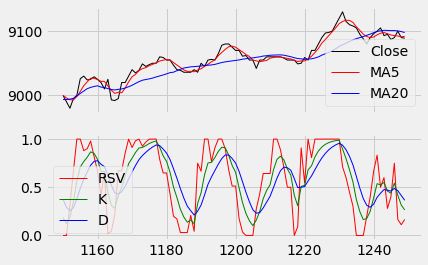

In [459]:
plt.style.use('fivethirtyeight')
ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1),(1,0), sharex= ax1)
X[['Close','MA5', 'MA20']].iloc[1150:1250].plot(ax= ax1, linewidth=1, color=['k','r','b'])
X[['RSV','K','D']].iloc[1150:1250].plot(ax= ax2, linewidth=1, color=['r','g','b'])
plt.show()

In [504]:
clf = sklearn.neighbors.KNeighborsClassifier()

clf.fit(train_x,  train_y)

accuracy = clf.score(test_x, test_y)

print ('accuracy', accuracy)

accuracy 0.5071990406538701


In [505]:
result = clf.predict(test_x)

In [506]:
result

array([0, 0, 0, ..., 1, 1, 1])

In [507]:
STRAT = X.iloc[train_n:].drop(['Date', 'Time', 'Open', 'High', 'Low', 'Volume', 'y'], axis=1).fillna(0)
STRAT['POSITION'] = -result
#STRAT['POSITION'] = np.where(STRAT['POSITION']>0.5, -1, 1)

In [508]:
len(result)

253506

In [509]:
STRAT

,Close,MA5,MA10,MA20,RSV,K,D,TR,ATR,TRMA,DM_P,DM_N,ADM_P,ADM_N,DX,ADX,SIGNAL,SIGN,POSITION
1014023,8468.0,8467.2,8469.1,8471.75,0.111111,0.175569,0.190467,2.0,2.405953,2.400000,0.0,0.0,0.217549,0.662961,50.585705,31.614831,0,0.0,0
1014024,8469.0,8465.8,8468.0,8471.10,0.000000,0.117046,0.165993,5.0,2.578890,2.600000,0.0,4.0,0.203046,0.885430,62.691756,33.686626,0,0.0,0
1014025,8467.0,8464.6,8466.8,8470.40,0.000000,0.078031,0.136672,3.0,2.606964,2.600000,0.0,1.0,0.189509,0.893068,64.989251,35.773468,0,0.0,0
1014026,8466.0,8463.6,8465.7,8469.65,0.250000,0.135354,0.136233,5.0,2.766499,2.800000,0.0,3.0,0.176875,1.033530,70.774212,38.106851,0,0.0,0
1014027,8468.0,8462.2,8464.9,8468.95,0.250000,0.173569,0.148678,2.0,2.715399,2.866667,0.0,0.0,0.165084,0.964628,70.774212,40.284675,1,0.0,0
1014028,8466.0,8461.2,8464.2,8468.30,0.250000,0.199046,0.165468,3.0,2.734373,2.866667,0.0,1.0,0.154078,0.966987,72.512190,42.433176,1,0.0,0
1014029,8462.0,8460.2,8463.0,8467.45,0.076923,0.158338,0.163091,6.0,2.952081,3.200000,0.0,4.0,0.143806,1.169187,78.094915,44.810625,1,0.0,0
1014030,8461.0,8460.4,8462.5,8466.90,0.538462,0.285046,0.203743,9.0,3.355276,3.666667,2.0,1.0,0.267552,1.157908,62.460917,45.987311,1,0.0,0
1014031,8461.0,8462.2,8462.9,8466.65,1.000000,0.523364,0.310283,9.0,3.731591,4.133333,6.0,0.0,0.649716,1.080714,24.907033,44.581959,1,0.0,0
1014032,8461.0,8463.6,8462.9,8466.30,0.684211,0.576980,0.399182,6.0,3.882818,4.333333,4.0,0.0,0.873068,1.008667,7.206055,42.090232,1,1.0,0


In [510]:
STRAT['POSITION'].iloc[:200]

1014023    0
1014024    0
1014025    0
1014026    0
1014027    0
1014028    0
1014029    0
1014030    0
1014031    0
1014032    0
1014033    0
1014034    0
1014035    0
1014036    0
1014037    0
1014038    0
1014039    0
1014040    0
1014041    0
1014042    0
1014043   -1
1014044   -1
1014045    0
1014046   -1
1014047    0
1014048    0
1014049    0
1014050   -1
1014051   -1
1014052   -1
          ..
1014193   -1
1014194   -1
1014195   -1
1014196   -1
1014197   -1
1014198   -1
1014199   -1
1014200   -1
1014201   -1
1014202   -1
1014203   -1
1014204   -1
1014205   -1
1014206    0
1014207    0
1014208    0
1014209    0
1014210    0
1014211   -1
1014212    0
1014213    0
1014214   -1
1014215    0
1014216    0
1014217   -1
1014218   -1
1014219   -1
1014220   -1
1014221    0
1014222    0
Name: POSITION, Length: 200, dtype: int64

In [511]:
STRAT['RETURN'] = STRAT['Close'].pct_change()
STRAT['SIGNAL_RETURN'] = STRAT['POSITION'].shift(1) * STRAT['RETURN']
STRAT['EQUITY'] = STRAT['SIGNAL_RETURN'].cumsum().apply(np.exp)
STRAT['DRAWDOWN'] = STRAT['EQUITY'] - STRAT['EQUITY'].cummax()
STRAT['MKT'] = STRAT['RETURN'].cumsum().apply(np.exp)

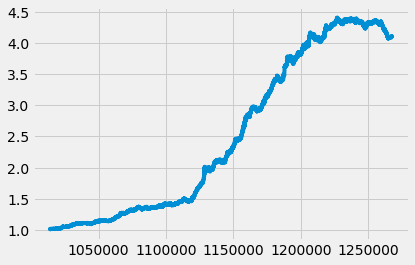

In [512]:
plt.plot(STRAT['EQUITY'])

# LSTM model

In [271]:
def lstm_model(input_size,time_steps,output_size):

    # 設定輸入資料維度並經由 128*input size 的矩陣做轉換傳給下一個 time steps
    network = input_data(shape=[None,time_steps,input_size], name='input')
    network = lstm(network,128, dropout=0.8,forget_bias=0.8)

    # 這邊我用兩個 fully connection
    network = fully_connected(network, 32, activation='relu')
    network = dropout(network, 0.8)

    # softmax 輸出成機率
    network = fully_connected(network, output_size, activation='softmax')
    network = regression(network, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

    model = tflearn.DNN(network, tensorboard_dir='log', tensorboard_verbose=1)

    return model


def train_model(tr_X,tr_y,te_X, te_y, model=False):

    # 獲得輸入資料維度
    input_size = len(np.array(tr_X)[0])
    time_steps = len(tr_X)

    # 轉換資料為訓練和測試組
    tr_X = np.array(tr_X)
    te_X = np.array(te_X)

    tr_y = np.array(tr_y)
    te_y = np.array(te_y)

    if not model:
        model = lstm_model(input_size,time_steps,len(te_y))

    # 最佳化 LSTM model
    model.fit({'input': tr_X}, {'targets': tr_y},validation_set=(te_X, te_y), n_epoch=5, snapshot_step=1103, show_metric=True, run_id='tx_learning')

    return model

In [272]:
model = train_model(train_x, train_y,test_x, test_y)


KeyboardInterrupt: 

# Reinforcement Learning

In [282]:
df['SIGNAL'] = np.where(df['MA5']>df['MA10'], 1, -1)
df['RETURN'] = df['Close'].pct_change()
df['SIGNAL_RETURN'] = df['SIGNAL'].shift(1) * df['RETURN']
df['EQUITY'] = df['SIGNAL_RETURN'].cumsum().apply(np.exp)
df['DRAWDOWN'] = df['EQUITY'] - df['EQUITY'].cummax()

In [ ]:
plt.plot(df['EQUITY'])

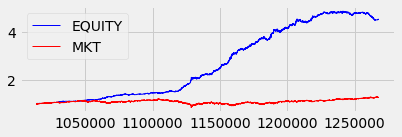

In [441]:
plt.style.use('fivethirtyeight')
ax1 = plt.subplot2grid((2,1),(0,0))
#ax2 = plt.subplot2grid((2,1),(1,0), sharex= ax1)
STRAT[['EQUITY', 'MKT']].plot(ax= ax1, linewidth=1, color=['b', 'r'])
#X[['RSV','K','D']].iloc[1150:1250].plot(ax= ax2, linewidth=1, color=['r','g','b'])
plt.show()

In [ ]:
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions  # a list
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)
        # action selection
        if np.random.uniform() < self.epsilon:
            # choose best action
            state_action = self.q_table.loc[observation, :]
            state_action = state_action.reindex(np.random.permutation(state_action.index))     # some actions have same value
            action = state_action.idxmax()
        else:
            # choose random action
            action = np.random.choice(self.actions)
        return action

    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        q_predict = self.q_table.loc[s, a]
        if s_ != 'terminal':
            q_target = r + self.gamma * self.q_table.loc[s_, :].max()  # next state is not terminal
        else:
            q_target = r  # next state is terminal
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)  # update

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            # append new state to q table
            self.q_table = self.q_table.append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )

In [ ]:
def update():
    for episode in range(100):
        # initial observation
        observation = env.reset()

        while True:
            # fresh env
            env.render()

            # RL choose action based on observation
            action = RL.choose_action(str(observation))

            # RL take action and get next observation and reward
            observation_, reward, done = env.step(action)

            # RL learn from this transition
            RL.learn(str(observation), action, reward, str(observation_))

            # swap observation
            observation = observation_

            # break while loop when end of this episode
            if done:
                break

    # end of game
    print('game over')
    env.destroy()

if __name__ == "__main__":
    env = Maze()
    RL = QLearningTable(actions=list(range(env.n_actions)))

    env.after(100, update)
    env.mainloop()